NY Rental Analysis

In [3]:
pip install researchpy

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Dependencies and set up
import os
import csv
import hvplot.pandas
import pandas as pd
import requests
from pathlib import Path
import numpy as np
import requests
import time
import matplotlib.pyplot as plt
from scipy.stats import linregress
import researchpy as rp
import scipy.stats as stats

In [7]:
# Set path for file
import csv
csv_file = os.path.join("NY Realstate Pricing.csv")
realestate_data_df = pd.read_csv(csv_file)

# Display sample data
realestate_data_df.head()

,F1,id,neighbourhood,latitude,longitude,room_type,price,days_occupied_in_2019,minimum_nights,number_of_reviews,reviews_per_month,availability_2020
0,0,2595,Midtown,40.75362,-73.98377,Entire home/apt,225,15,10,48,0.39,1
1,1,3831,Brooklyn,40.68514,-73.95976,Entire home/apt,89,188,1,295,4.67,1
2,2,5099,Manhattan,40.74767,-73.97500,Entire home/apt,200,362,3,78,0.60,19
3,3,5121,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,0,29,49,0.38,365
4,4,5178,Manhattan,40.76489,-73.98493,Private room,79,141,2,454,3.52,242


In [8]:
#checking the number of neighbourhoods in NY
realestate_data_df["neighbourhood"].value_counts()

Brooklyn              3875
Manhattan             3229
Queens                1099
Bedford-Stuyvesant     799
Harlem                 632
                      ... 
Sea Gate                 1
Marble Hill              1
Midland Beach            1
Mill Basin               1
Van Nest                 1
Name: neighbourhood, Length: 186, dtype: int64

In [9]:
#clean data
realestate_data_clean_df = realestate_data_df.dropna() 


# Drop any rows with null values
#perferred_cities = perferred_cities.dropna()

# Display sample data
realestate_data_clean_df.head()

,F1,id,neighbourhood,latitude,longitude,room_type,price,days_occupied_in_2019,minimum_nights,number_of_reviews,reviews_per_month,availability_2020
0,0,2595,Midtown,40.75362,-73.98377,Entire home/apt,225,15,10,48,0.39,1
1,1,3831,Brooklyn,40.68514,-73.95976,Entire home/apt,89,188,1,295,4.67,1
2,2,5099,Manhattan,40.74767,-73.97500,Entire home/apt,200,362,3,78,0.60,19
3,3,5121,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,0,29,49,0.38,365
4,4,5178,Manhattan,40.76489,-73.98493,Private room,79,141,2,454,3.52,242


In [10]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the days_occuppied_in_2019 for each room type
daysoccupied = realestate_data_clean_df.groupby(["room_type"])
# Use groupby and summary statistical methods to calculate the following properties of each room type: 
# mean, median, variance, standard deviation, and SEM of the occupancy rate. 
# Assemble the resulting series into a single summary DataFrame.
daysoccupied_mean = daysoccupied["days_occupied_in_2019"].mean()
daysoccupied_median = daysoccupied["days_occupied_in_2019"].median()
daysoccupied_var = daysoccupied["days_occupied_in_2019"].var()
daysoccupied_std = daysoccupied["days_occupied_in_2019"].std()
daysoccupied_sem = daysoccupied["days_occupied_in_2019"].sem()

daysoccupied_df = pd.DataFrame({
                        "Mean": daysoccupied_mean,
                        "Median" : daysoccupied_median,
                        "Variance": daysoccupied_var,
                        "Standard Deviation": daysoccupied_std,
                        "SEM": daysoccupied_sem,
})

daysoccupied_df

,Mean,Median,Variance,Standard Deviation,SEM
room_type,,,,,
Entire home/apt,185.165231,200.0,16986.175375,130.331022,1.343904
Hotel room,83.500000,14.5,13106.878788,114.485278,11.448528
Private room,175.723297,198.0,16689.546055,129.188026,1.467288
Shared room,140.022409,83.0,17693.482642,133.016851,7.039998


In [12]:
#ANOVA
stats.f_oneway(realestate_data_clean_df['days_occupied_in_2019'][realestate_data_clean_df['price'] == 'high'],
               realestate_data_clean_df['days_occupied_in_2019'][realestate_data_clean_df['price'] == 'low']
            )

c:\Users\becsh\OneDrive\Documents\anaconda\envs\dev\lib\site-packages\scipy\stats\_stats_py.py:3861: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


F_onewayResult(statistic=nan, pvalue=nan)

In [13]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('days_occupied_in_2019 ~ C(price)', data=realestate_data_clean_df).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
C(price),1.227506e+07,460.0,1.598706,1.489314e-14
Residual,2.863105e+08,17153.0,NaN,NaN


In [15]:
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']

    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])

    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])

    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

anova_table(aov_table)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(price),1.227506e+07,460.0,26684.910503,1.598706,1.489314e-14,0.041111,0.015395
Residual,2.863105e+08,17153.0,16691.567724,NaN,NaN,NaN,NaN


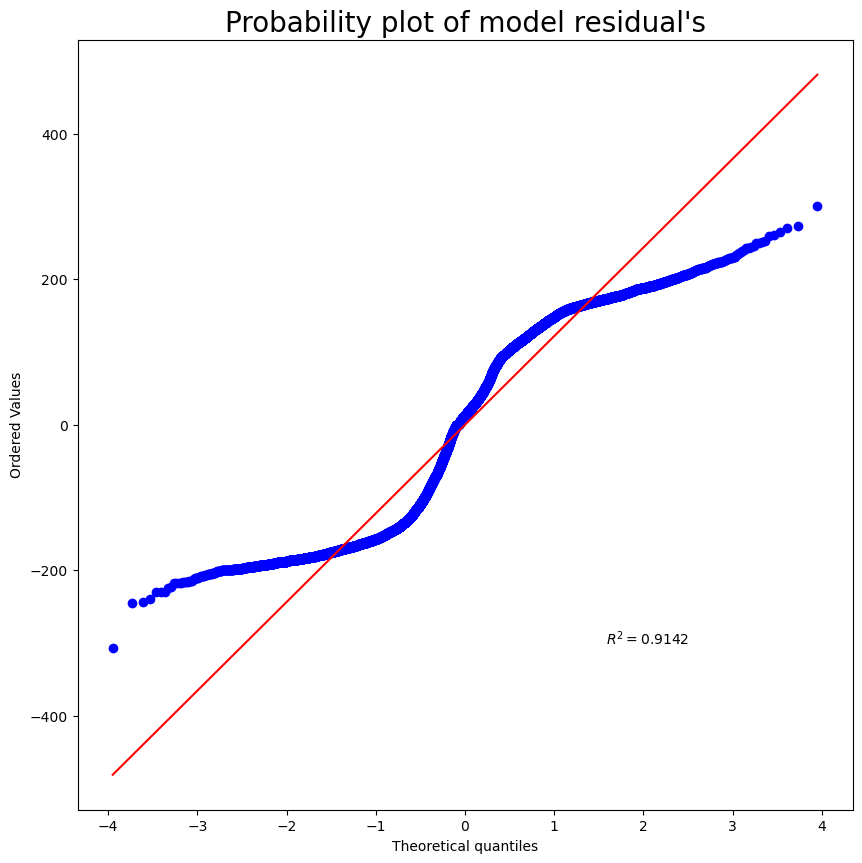

In [16]:
fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(model.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of model residual's", fontsize= 20)
ax.set

plt.show()

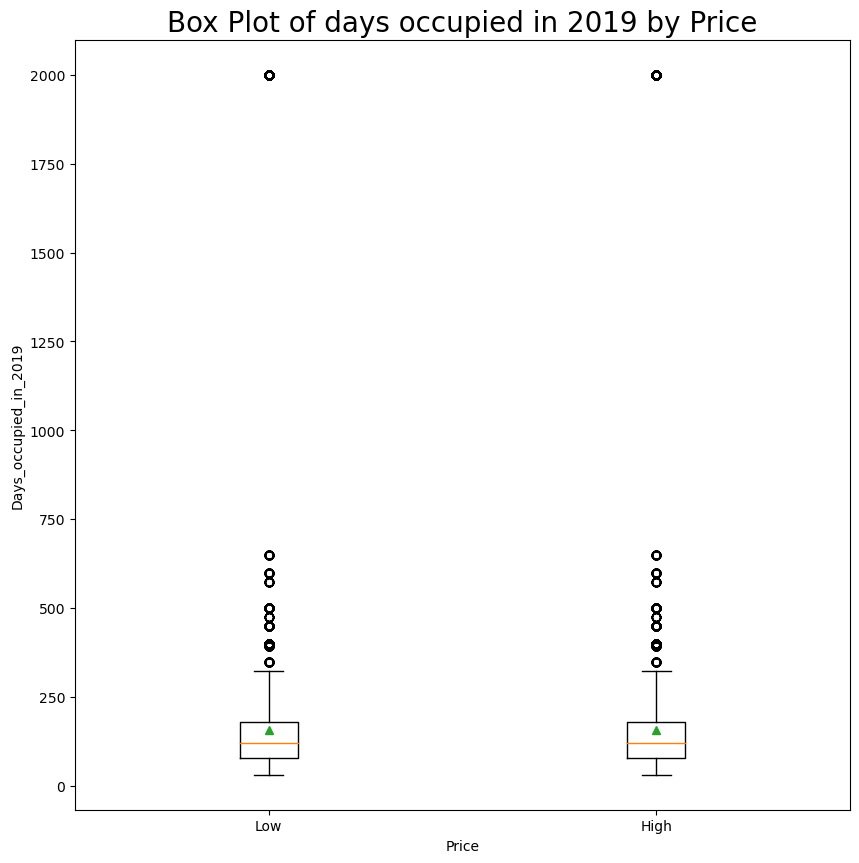

In [18]:
fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

ax.set_title("Box Plot of days occupied in 2019 by Price", fontsize= 20)
ax.set

data = [realestate_data_clean_df['price'][realestate_data_clean_df['days_occupied_in_2019']],
        realestate_data_clean_df['price'][realestate_data_clean_df['days_occupied_in_2019']]
        ]

ax.boxplot(data,
           labels= ['Low', 'High'],
           showmeans= True)

plt.xlabel("Price")
plt.ylabel("Days_occupied_in_2019")

plt.show()

In [ ]:
# Generate a bar plot showing the total number of timepoints for all mice tested for each drug regimen using Pandas.
timepoint = realestate_data_df.groupby(["room_type"])["price"].count()
timepoint.sort_values(ascending=False).plot.bar()

timepoint.show()


In [ ]:
# 1 - Pie chart
room_type = data.groupby('room_type')['latitude'].count().reset_index()
room_type.rename(columns={'latitude':'n_rooms'},inplace=True)
plt.figure(figsize=(10,8))
plt.pie(room_type['n_rooms'],autopct='%1.2f%%', colors=['darkcyan', 'steelblue','powderblue'])
plt.axis('equal')
plt.legend(labels=room_type['room_type'],loc='best',fontsize='12')
plt.title('Room-type Rental Distribution', fontsize='15',color='b')
plt.show()
plt.close()

ValueError: could not convert string to float: 'Entire home/apt'

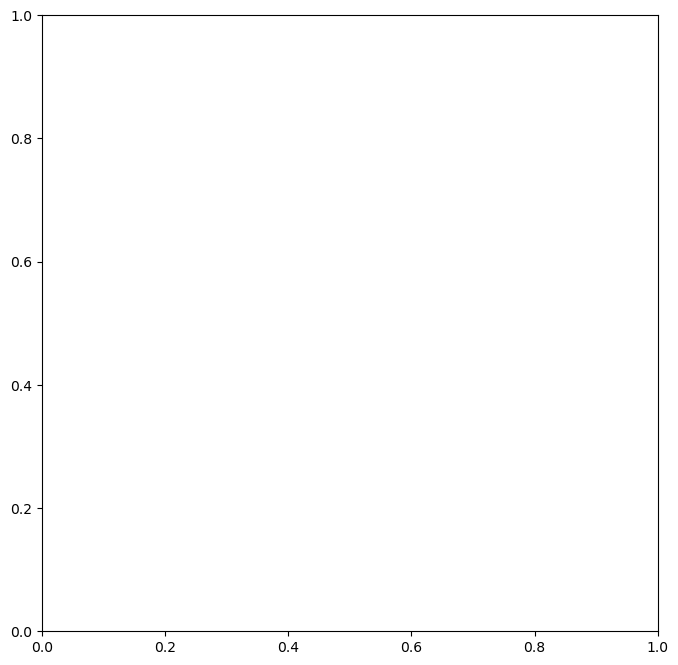

In [54]:
# Generate a pie plot showing the distribution of room type 
room_type = realestate_data_clean_df.groupby('room_type')['latitude'].count().reset_index()
room_type.rename(columns={'latitude':'room_type'},inplace=True)
plt.figure(figsize=(10,8))
plt.pie(room_type['room_type'],autopct='%1.2f%%', colors=['darkcyan', 'steelblue','powderblue'])
plt.axis('equal')
plt.legend(labels=room_type['room_type'],loc='best',fontsize='12')
plt.title('Room-type Rental Distribution', fontsize='15',color='b')
plt.show()
plt.close()

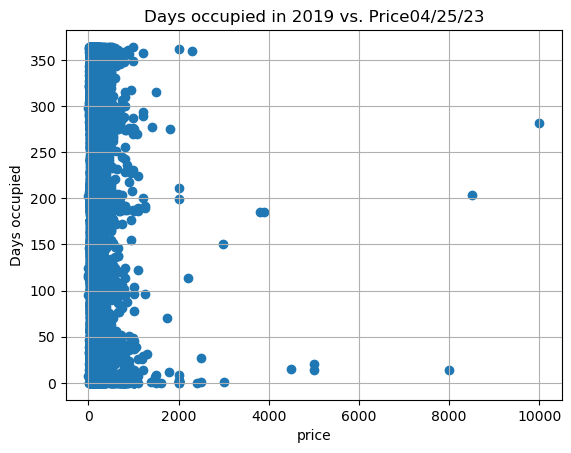

In [48]:
# Build scatter plot for days_occupied_2019 vs. price
x_values = realestate_data_clean_df['price']
y_values = realestate_data_clean_df['days_occupied_in_2019']
plt.scatter(x_values,y_values)

# Incorporate the other graph properties
plt.title(f"Days occupied in 2019 vs. Price" + time.strftime("%x"))
plt.ylabel("Days occupied")
plt.xlabel("price")
plt.grid(True)

# Save the figure
plt.savefig("output/Fig1.png")

# Show plot
plt.show()

In [ ]:
# Define a function to create Linear Regression plots
#def plot_linear_regression(x_values, y_values, title, y_label, text_coordinates)
(slope, intercept, r_value, p_value, std_err)= linregress(x_values, y_values)

In [50]:
# Linear regression 
x_values = realestate_data_clean_df["room_type"]
y_values = realestate_data_clean_df['price']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(50,26),fontsize=15,color="red")
plt.xlabel('Room Type')
plt.ylabel('Price')
print(f"The r-squared is: {rvalue**2}")
plt.show()

TypeError: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (5,) and arg 1 with shape (166,).

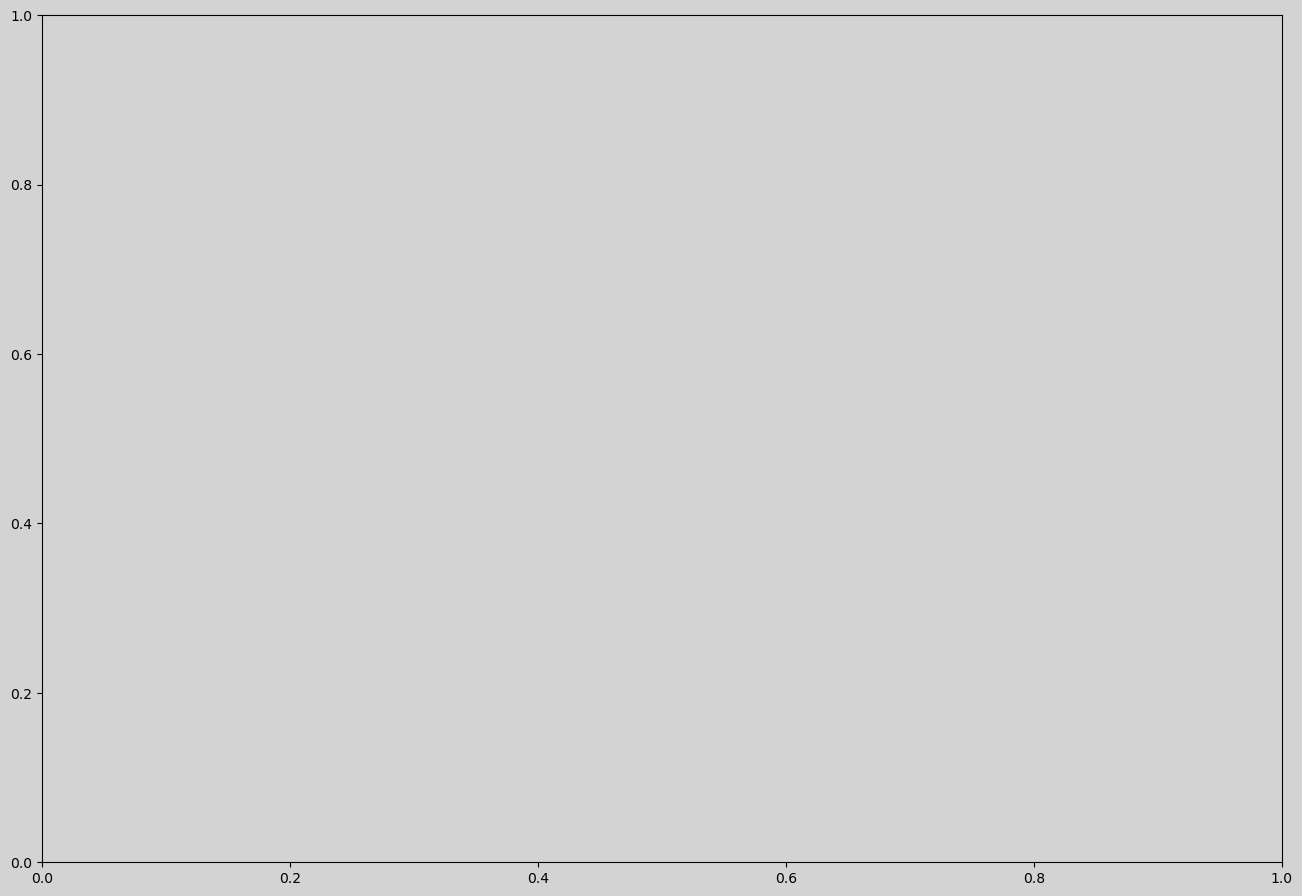

In [57]:
loc_price = realestate_data_clean_df.groupby(['neighbourhood','room_type'])['price'].mean().reset_index()
locations = loc_price.neighbourhood.unique()
x_rooms1 = [0.8, 3.8, 6.8, 9.8, 12.8]
x_rooms2 = [1.6, 4.6, 7.6, 10.6, 13.6]
x_rooms3 = [2.4, 5.4, 8.4, 11.4, 14.4]
y_values1 = loc_price[loc_price['room_type'] == 'Entire home/apt']['price'].values
y_values2 = loc_price[loc_price['room_type'] == 'Private room']['price'].values
y_values3 = loc_price[loc_price['room_type'] == 'Shared room']['price'].values
fig3,ax2 = plt.subplots(figsize=(16,11))
fig3.patch.set_facecolor('lightgray')
ax2.set_facecolor('lightgray')
plt.bar(x_rooms1, y_values1, color='purple', edgecolor='b')
plt.bar(x_rooms2, y_values2, color='b', edgecolor='b')
plt.bar(x_rooms3, y_values3, color='yellowgreen', edgecolor='b')
ax2.set_xticks(range(1,16,3))
ax2.set_xticklabels(locations, fontsize='12')
for tick in ax2.get_xticklabels():
    tick.set_rotation(45)
plt.xlabel('Location/Room-type',fontsize='15')
plt.ylabel('Prices', fontsize='15')
plt.legend(labels=loc_price.room_type.unique(), loc='best')
plt.title('New York Price-Rental Distribution by Location and Room-type',fontsize='15')
plt.show()